In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt

sns.set_theme()

In [105]:
jan_df = pd.read_csv('monthly-sales-of-company-x-jan-6.csv')
boston = pd.read_csv('monthly-boston-armed-robberies-j.csv')
air_df = pd.read_csv('international-airline-passengers.csv')

mean_tmp = pd.read_csv( 'mean-monthly-air-temperature-deg.csv')
weekly = pd.read_csv( 'weekly-closings-of-the-dowjones-.csv')
daily_female = pd.read_csv('daily-total-female-births-in-cal.csv')


titles = {'company_x':jan_df['Count'],
          'boston':boston['Count'],
          'air':air_df['Count'],
          'mean_tmp':mean_tmp['Deg'],
          'weekly':weekly['Close'],
          'daily_female':daily_female['Count']
         }

На одном ряде реализуем три визуализации из statsmodel

C:\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


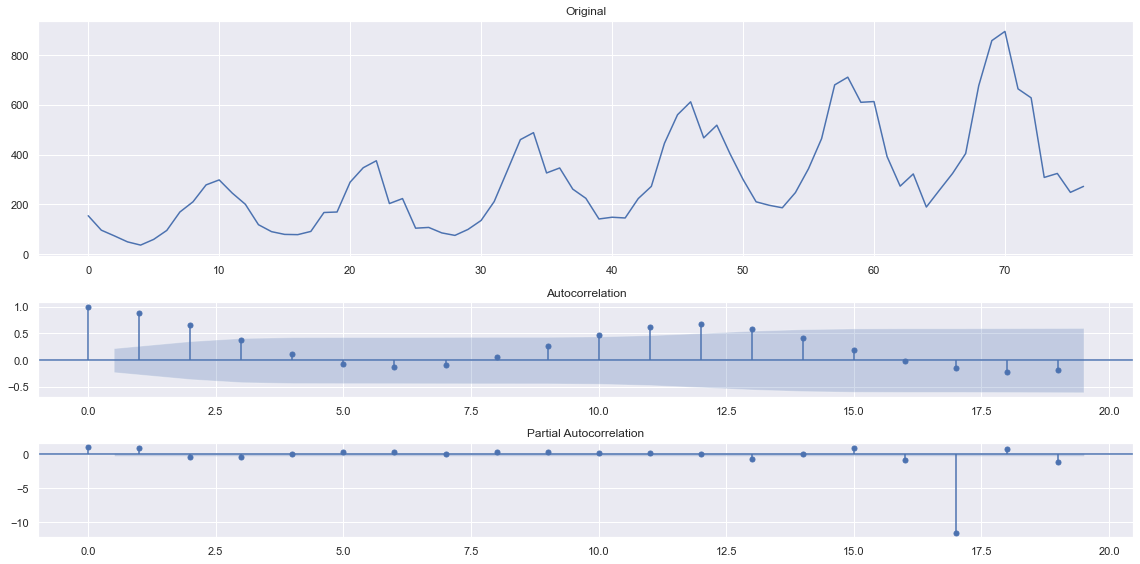

In [106]:
layout = (4, 1)
plt.figure(figsize=(16, 8))

ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
acf_ax = plt.subplot2grid(layout, (2, 0))
pacf_ax = plt.subplot2grid(layout, (3, 0))

jan_df['Count'].plot(ax=ts_ax)
ts_ax.set_title('Original')

smt.graphics.plot_acf(jan_df['Count'], alpha=0.05, ax=acf_ax)
smt.graphics.plot_pacf(jan_df['Count'], ax=pacf_ax, alpha=0.05)
plt.tight_layout()

In [107]:
def plot_(data):
    plt.figure(figsize=(16, 14))

    for n,i in enumerate(data.items()):
        plt.subplot(len(data.keys()),1,n+1)
        plt.plot(i[1])
        plt.tight_layout(h_pad= 3 )
        plt.title(i[0])

Автокорреляиця для company_x: 0.9888894205170052
Автокорреляиця для boston: 0.9942775638057231
Автокорреляиця для air: 0.9918802434376409
Автокорреляиця для mean_tmp: 0.016989030222608826
Автокорреляиця для weekly: 0.6224548515589732
Автокорреляиця для daily_female: 5.2434129901498554e-05


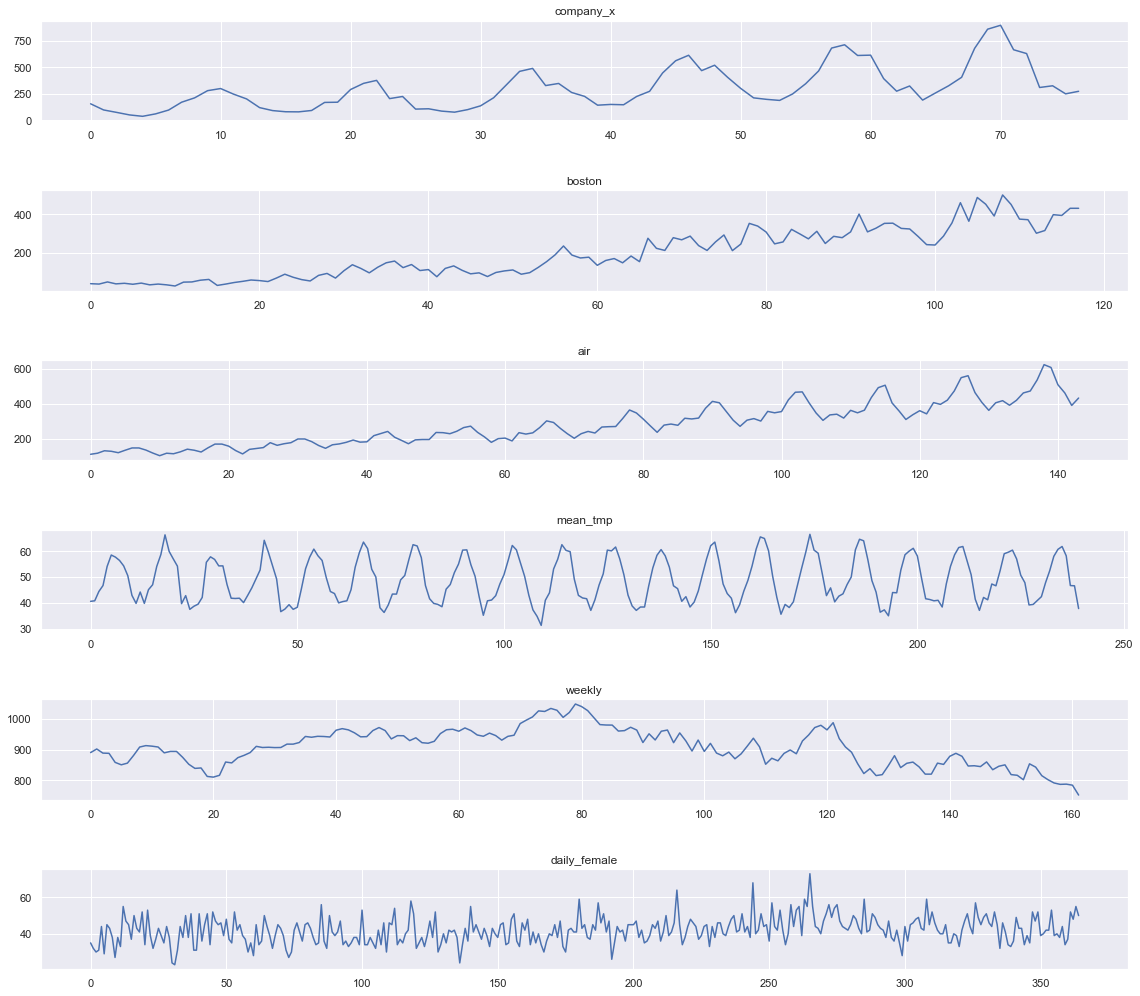

In [108]:
plot_(titles)

for i in titles.items():
    print(f'Автокорреляиця для {i[0]}:', adfuller(i[1], autolag='AIC')[1])

* Согласно тесту Дики-Фуллера ряды daily_female (дневной рождаемости) и mean_tmp (средней температуры) уже стационарны
* Их дальнейшее преобразование не требуется, но ради интереса прогоним через преобразования и их

Автокорреляиця для company_x: 0.785310212484911
Автокорреляиця для boston: 0.2808325035425546
Автокорреляиця для air: 0.4223667747703857
Автокорреляиця для mean_tmp: 0.003332556252533504
Автокорреляиця для weekly: 0.6691194827577257
Автокорреляиця для daily_female: 0.0003588965449025562


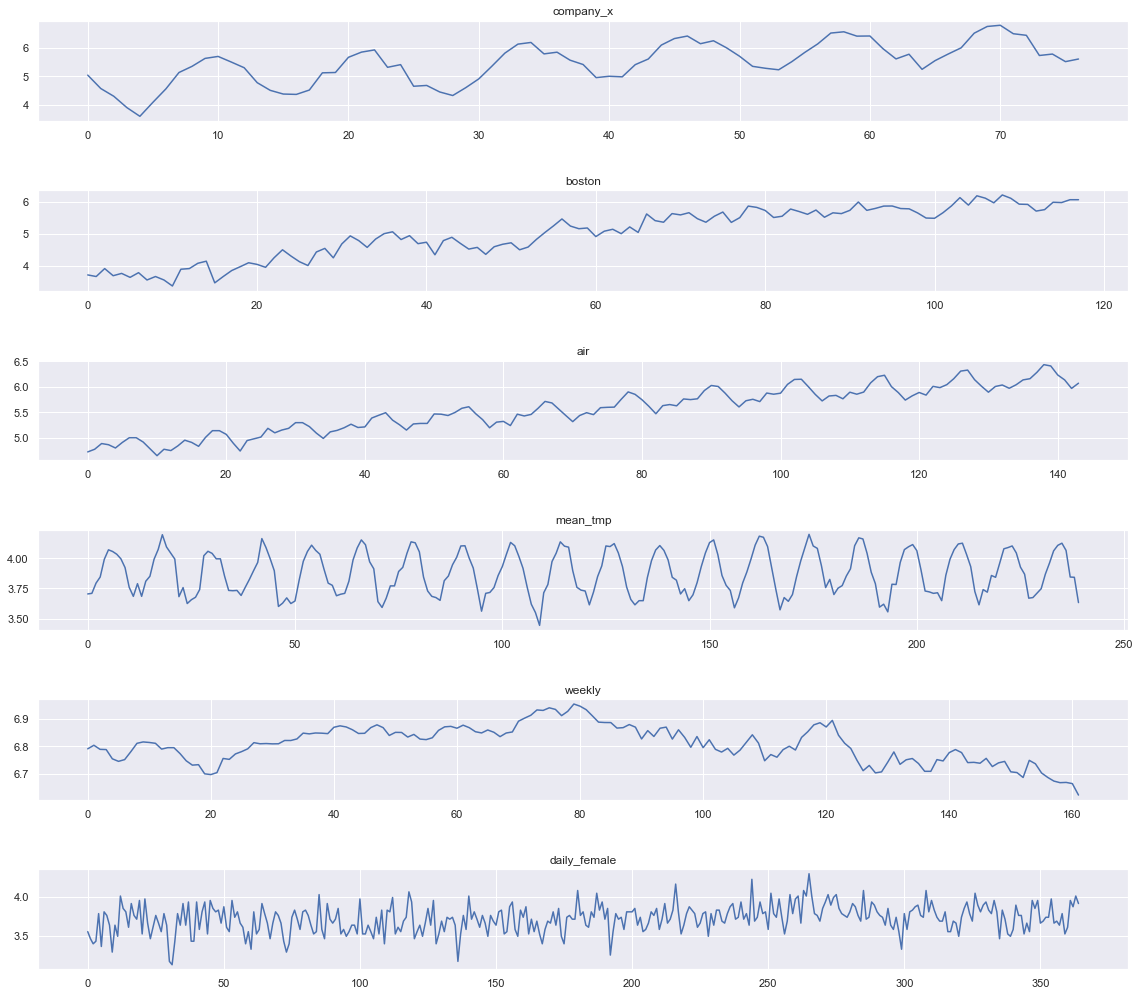

In [109]:
after_box={}

for i in titles.items():
    after_box[i[0]]= boxcox(i[1],0)

for i in after_box.items():
    print(f'Автокорреляиця для {i[0]}:', adfuller(i[1], autolag='AIC')[1])
    
plot_(after_box)

* После снижение дисперсии нестационарные ряды стали менее нестационарными
* Те, которые уже были стационарными, стали еще более стационарными


Автокорреляиця для company_x: 0.02402539283987568
Автокорреляиця для boston: 2.3786024417438203e-11
Автокорреляиця для air: 0.0711205481508568
Автокорреляиця для mean_tmp: 1.6407281304677816e-22
Автокорреляиця для weekly: 2.751609132291384e-24
Автокорреляиця для daily_female: 3.1912045858778697e-24


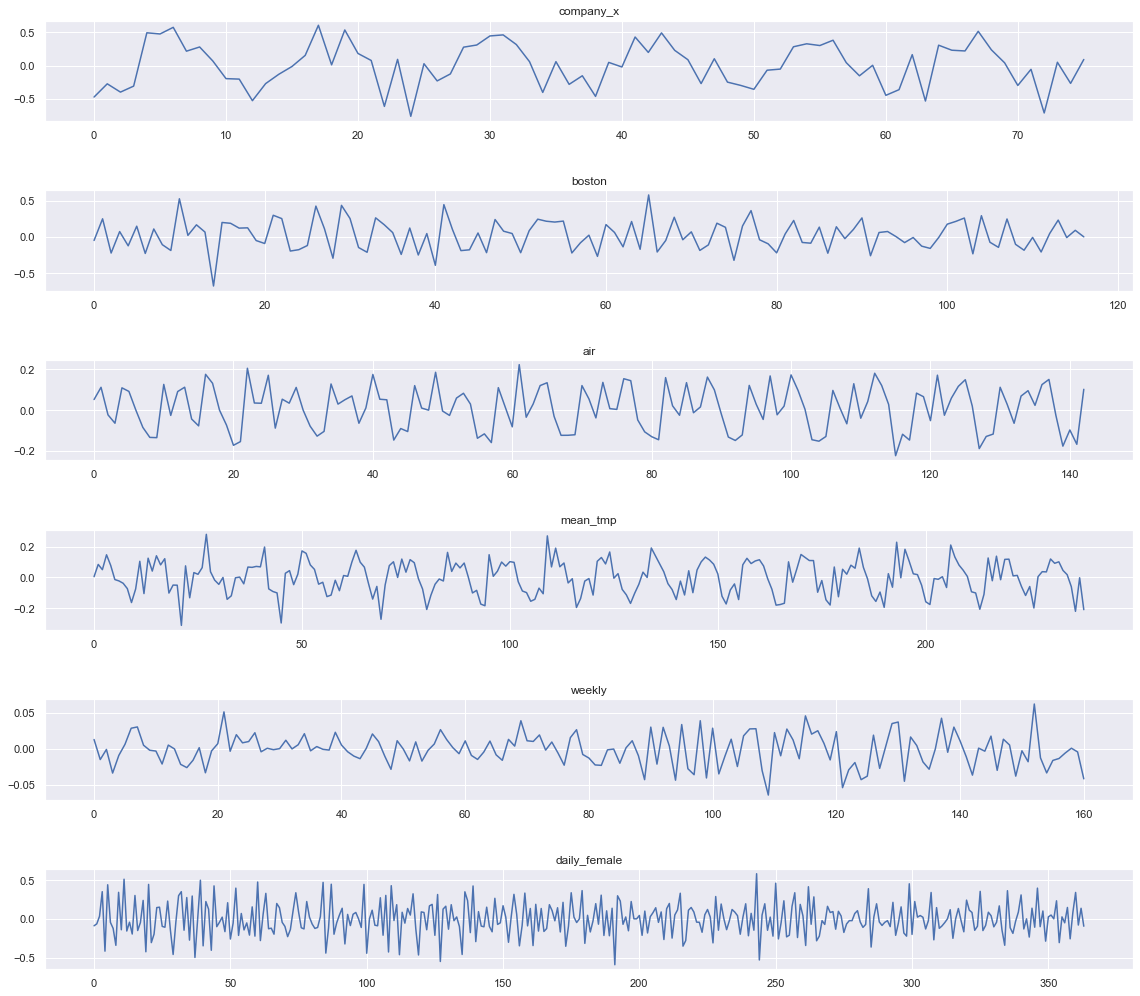

In [110]:
after_box_and_diff = {}
for i in after_box.items():
    after_box_and_diff[i[0]]= np.diff(i[1], 1)
    
for i in after_box_and_diff.items():
    print(f'Автокорреляиця для {i[0]}:', adfuller(i[1], autolag='AIC')[1])
plot_(after_box_and_diff)    

* На данном этапе после удаления тренда тест Дики-Фулера уже показывает, что 5 из 6 рядов теперь могут рассматриваться как стационарные 
* Нестационарным остается ряд air с перелетами, попробуем решить его проблему через удаление сезонности 12 месяцев

Автокорреляиця для company_x: 0.1668454967417884
Автокорреляиця для boston: 0.0005791258821324685
Автокорреляиця для air: 0.0002485912311384209
Автокорреляиця для mean_tmp: 2.3611635224726745e-12
Автокорреляиця для weekly: 0.009871226530993187
Автокорреляиця для daily_female: 4.892374998452764e-14


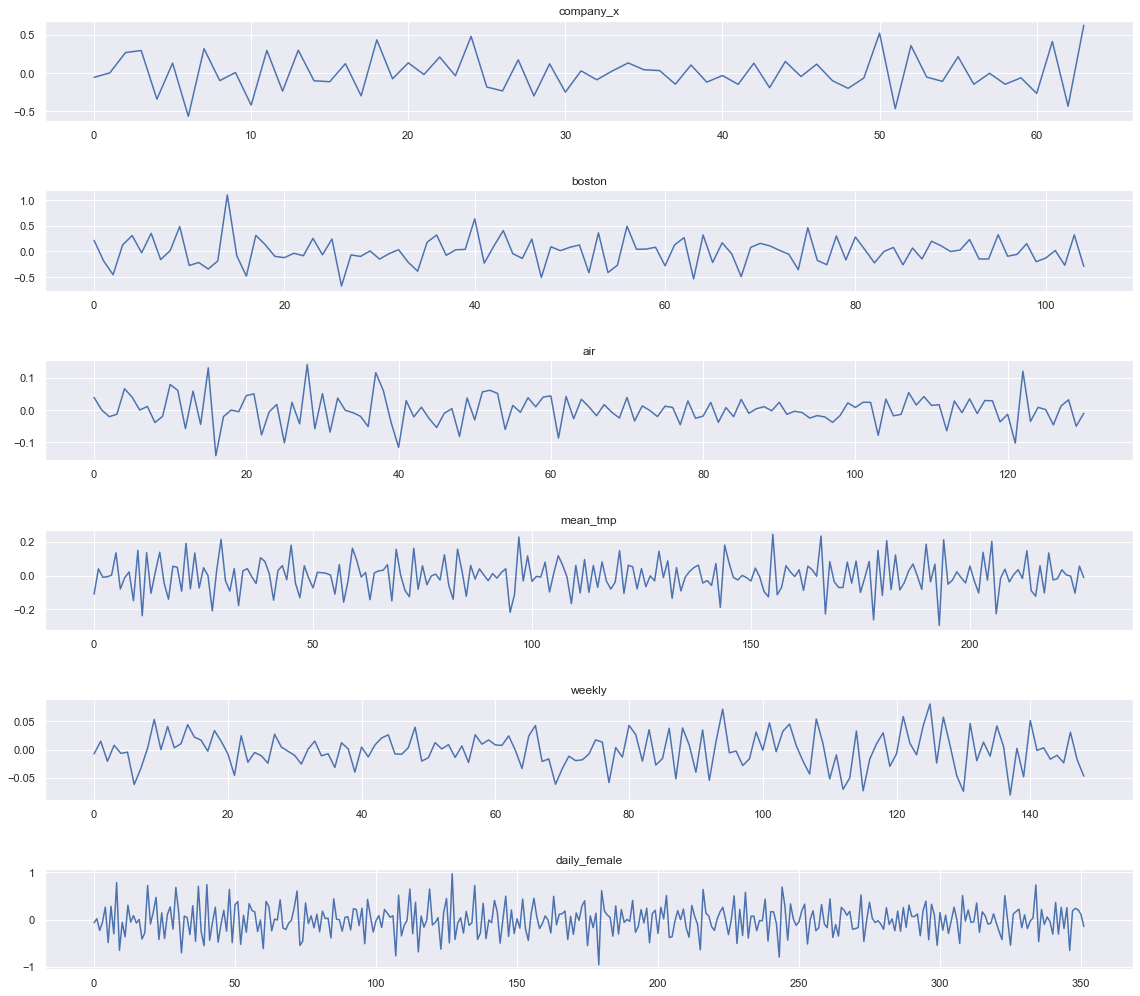

In [111]:
ending = {}

for i in after_box_and_diff.items():
    no_cycle = i[1][12:]-i[1][:-12]
    ending[i[0]]=no_cycle
    
for i in ending.items():
    print(f'Автокорреляиця для {i[0]}:', adfuller(i[1], autolag='AIC')[1])
plot_(ending) 

## Итог:
* Ранее проблемный ряд air теперь можно рассматривать как стационарный
* Но ранее стационарный ряд стал нестационарным
* Это связано с тем, что в данном алгоритме все ряды обрабатываются на сезонность по одному шаблону
* Очевидно, для этого ряда имеет местоиная сезонность, с которой надо поработаь индивидуально